In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Circle
import networkx as nx
import numpy as np
import os

# --- KONFIGURASI FOLDER ---
DATA_DIR = 'data'  # Pastikan folder ini benar

def load_csv(filename):
    path = os.path.join(DATA_DIR, filename)
    try:
        df = pd.read_csv(path)
        print(f"✅ Berhasil load: {filename} ({len(df)} baris)")
        return df
    except FileNotFoundError:
        print(f"❌ ERROR: File {filename} tidak ditemukan di folder '{DATA_DIR}'")
        return None

print("--- 1. LOAD DATA SPASIAL (PETA) ---")
zone_df = load_csv('zone_config.csv')
nodes_df = load_csv('path_nodes.csv')
edges_df = load_csv('path_edges.csv')
gen_facilities_df = load_csv('general_facilities.csv') # Untuk visual (Pohon/Tong Sampah)

print("\n--- 2. LOAD DATA LOGIKA TAMAN ---")
park_facilities_df = load_csv('park_facilities.csv')   # Untuk kapasitas & fungsi (Bangku/Alat Gym)
activity_df = load_csv('activity_usage_profile.csv')   # Aturan aktivitas (Durasi/Energi)

print("\n--- 3. LOAD DATA DINAMIS (WAKTU & CUACA) ---")
arrival_df = load_csv('arrival_profile_weekend_counts.csv')
env_df = load_csv('env_schedule_weekend.csv')

print("\n--- 4. LOAD DATA AGEN (PENGUNJUNG) ---")
survey_df = load_csv('survey_preferences_1000.csv')

print("\n--- STATUS ---")
if all(v is not None for v in [zone_df, nodes_df, edges_df, gen_facilities_df, park_facilities_df, activity_df, arrival_df, env_df, survey_df]):
    print("🎉 SEMUA DATA SIAP! Silakan lanjut ke visualisasi.")
else:
    print("⚠️ Ada data yang hilang. Cek folder data kamu.")

--- 1. LOAD DATA SPASIAL (PETA) ---
✅ Berhasil load: zone_config.csv (31 baris)
✅ Berhasil load: path_nodes.csv (123 baris)
✅ Berhasil load: path_edges.csv (125 baris)
✅ Berhasil load: general_facilities.csv (79 baris)

--- 2. LOAD DATA LOGIKA TAMAN ---
✅ Berhasil load: park_facilities.csv (24 baris)
✅ Berhasil load: activity_usage_profile.csv (11 baris)

--- 3. LOAD DATA DINAMIS (WAKTU & CUACA) ---
✅ Berhasil load: arrival_profile_weekend_counts.csv (90 baris)
✅ Berhasil load: env_schedule_weekend.csv (90 baris)

--- 4. LOAD DATA AGEN (PENGUNJUNG) ---
✅ Berhasil load: survey_preferences_1000.csv (1000 baris)

--- STATUS ---
🎉 SEMUA DATA SIAP! Silakan lanjut ke visualisasi.


In [2]:
# --- BANGUN GRAPH JALAN ---
G = nx.Graph()

if nodes_df is not None and edges_df is not None:
    # Nodes
    for _, row in nodes_df.iterrows():
        G.add_node(row['node_id'], pos=(row['x_px'], row['y_px']))

    # Edges
    for _, row in edges_df.iterrows():
        G.add_edge(row['from_node'], row['to_node'])

    print(f"✅ Graph Jaringan Jalan Terbangun: {G.number_of_nodes()} titik, {G.number_of_edges()} jalur.")
else:
    print("❌ Gagal membangun graph karena data node/edge hilang.")

✅ Graph Jaringan Jalan Terbangun: 123 titik, 125 jalur.


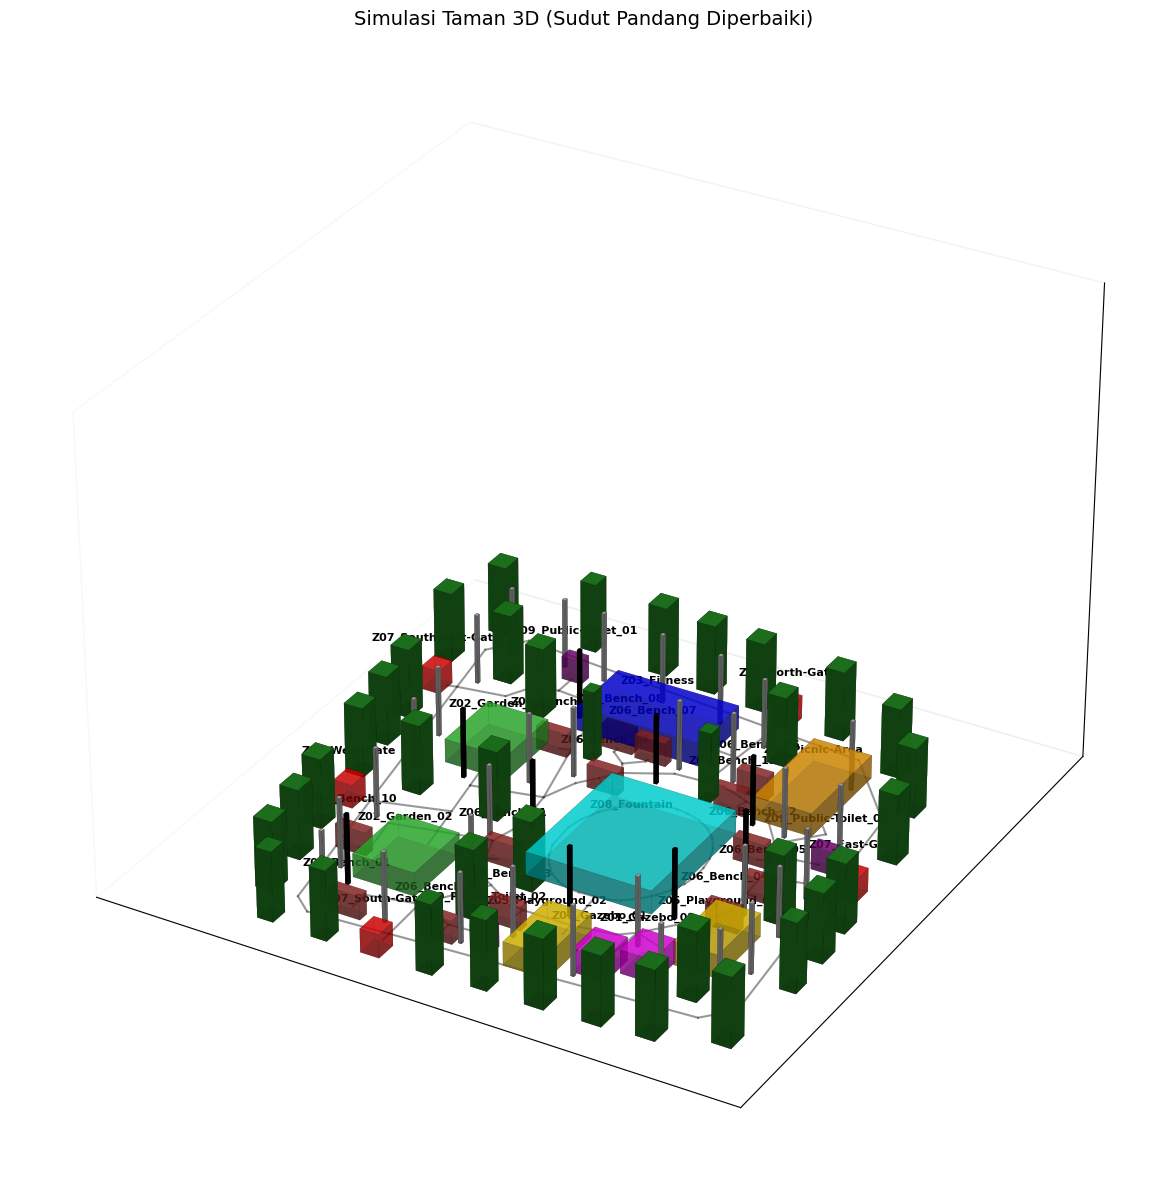

In [8]:
# --- 3. VISUALISASI 3D ISOMETRIK (SEPERTI PARK_ITER2) ---

def draw_park_3d(zones, visual_facilities, graph):
    if zones is None:
        print("Data zones tidak ditemukan.")
        return

    # Setup Canvas 3D
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Background putih agar bersih seperti referensi
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # Palet Warna (Sama seperti sebelumnya)
    COLORS = {
        "gazebo": "magenta", "garden": "limegreen", "fitness_zone": "blue",
        "picnic_area": "orange", "playground": "#ffd700", "fountain_zone": "cyan",
        "gate": "red", "public_toilet": "purple", "food_court": "pink",
        "bench_zone": "brown", "shelter": "teal", "indoor": "navy",
        "plaza": "#e0e0e0", "parking": "#d3d3d3", "running_track": "#a9a9a9",
        "tree": "#228b22", "trash_bin": "black"
    }

    # Fungsi helper untuk menggambar bar 3D
    def plot_3d_objects(df, is_facility=False):
        if df is None: return
        
        for _, row in df.iterrows():
            if is_facility:
                obj_type = row['facility_type']
                w, h = row.get('size1_px', 10), row.get('size2_px', 10)
                z_height = 15 # Tinggi standar untuk fasilitas kecil
            else:
                obj_type = row.get('zone_type', 'unknown')
                w, h = row['width_px'], row['height_px']
                z_height = 5 # Tinggi rendah untuk zona/tanah
            
            cx, cy = row['x_center_px'], row['y_center_px']
            
            # Koordinat sudut kiri bawah (anchor point untuk bar3d)
            x = cx - (w / 2)
            y = cy - (h / 2)
            z = 0 
            
            color = COLORS.get(obj_type, '#cccccc')
            alpha = 0.9 if is_facility else 0.6
            
            # Gambar Balok 3D
            ax.bar3d(x, y, z, w, h, z_height, color=color, alpha=alpha, edgecolor='k', linewidth=0.1, shade=True)
            
            # Label ID (hanya untuk Zona)
            if not is_facility and 'zone_id' in row:
                ax.text(cx, cy, z_height + 5, str(row['zone_id']), color='black', fontsize=8, ha='center', fontweight='bold')

    # 1. Render Zona
    plot_3d_objects(zones, is_facility=False)
    
    # 2. Render Fasilitas (Pohon, Tong Sampah, dll)
    plot_3d_objects(visual_facilities, is_facility=True)

    # 3. Render Jalan (Graph) di lantai (z=0)
    if graph is not None:
        pos = nx.get_node_attributes(graph, 'pos')
        # Loop edges manual agar bisa di-plot di 3D
        for u, v in graph.edges():
            x = [pos[u][0], pos[v][0]]
            y = [pos[u][1], pos[v][1]]
            z = [0.5, 0.5] # Sedikit di atas 0 agar tidak tertutup lantai
            ax.plot(x, y, z, color='#333333', linewidth=1.5, alpha=0.5)

    # --- PENGATURAN SUDUT PANDANG (INI KUNCINYA) ---
    # elev=30: Ketinggian kamera (biar kelihatan tingginya)
    # azim=-60: Rotasi memutar (biar kelihatan sisi sampingnya)
    ax.view_init(elev=30, azim=-60)

    # Bersihkan Tampilan (Hilangkan Grid Dinding agar seperti Park_Iter2)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.grid(False)
    
    # Set Axis agar proporsional
    ax.invert_yaxis() # Balik Y agar sesuai koordinat layar (atas = 0)
    ax.set_zlim(0, 100) # Limit Z agar tidak terlalu gepeng
    
    # Hilangkan angka axis agar bersih
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

    plt.title("Simulasi Taman 3D (Sudut Pandang Diperbaiki)", fontsize=14)
    plt.tight_layout()
    plt.show()

# Jalankan Visualisasi
draw_park_3d(zone_df, gen_facilities_df, G)